## Network Measurements Lab - Homework #2
## Giacomo Sguotti - 10667547

In the attached .zip can be found:
*   This Jupiter Notebook
*   Three directories 26_03_22_captures/, 27_03_22_captures/ and 28_03_22_captures/ which contains tshark captures exported to .csv performed relatively on 26/03/22, 27/03/22 and 28/03/22
*   Three files 26_03_22.csv, 27_03_22.csv and 28_03_22.csv that contain DataFrames where each row contains a curl request stats obtained from the tshark captures described above on the specific day. These files are needed to run the 6th point of this Jupyter Notebook

All these must be uploaded in the root folder of the Jupiter Notebook to avoid errors during its execution.




##1. Construct the dataset

In [1]:
!apt-get install tshark

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libc-ares2 libcap2-bin liblua5.2-0 libmaxminddb0 libnl-genl-3-200 libpam-cap
  libpcap0.8 libsbc1 libsmi2ldbl libspandsp2 libwireshark-data libwireshark11
  libwiretap8 libwscodecs2 libwsutil9 wireshark-common
Suggested packages:
  mmdb-bin snmp-mibs-downloader wireshark-doc
The following NEW packages will be installed:
  libc-ares2 libcap2-bin liblua5.2-0 libmaxminddb0 libnl-genl-3-200 libpam-cap
  libpcap0.8 libsbc1 libsmi2ldbl libspandsp2 libwireshark-data libwireshark11
  libwiretap8 libwscodecs2 libwsutil9 tshark wireshark-common
0 upgraded, 17 newly installed, 0 to remove and 39 not upgraded.
Need to get 16.5 MB of archives.
After this operation, 95.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libcap2-bin amd64 1:2.25-1.2 [20.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic

This bash script, for each link in WEBSITES performs 10 curl requests and outputs a .csv  file (and optionally a .pcap file) for each of them.
Its execution can be avoided by uploading captures/.

In [6]:
%%shell
# LIST OF WEBSITES TO VISIT
WEBSITES="https://www.indiatimes.com https://www.washingtonpost.com https://www.ndtv.com https://www.cnbc.com https://www.timesofindia.com https://www.express.co.uk https://www.rt.com https://www.news18.com https://www.nypost.com https://www.abc.net.au https://www.bbc.co.uk https://www.msn.com https://www.cnn.com https://www.news.google.com https://www.dailymail.co.uk https://www.nytimes.com https://www.theguardian.com https://www.foxnews.com https://www.finance.yahoo.com https://www.news.yahoo.com"

# BPF FILTER TO APPLY, IT IGNORES ALL TRAFFIC BETWEEN SERVERS BELONGING TO THE SAME DATACENTER
# AND NON TCP TRAFFIC
FILTER="not (src net 172.16.0.0/12 && dst net 172.16.0.0/12) && tcp"

mkdir -p ./captures
# FOR EACH WEBSITE IN WEBSITES: START TSHARK CAPTURE IN BACKGROUND, PERFORM 10 CURLS AND KILL TSHARK
for i in $WEBSITES
do
  echo $i
  tshark -i eth0 -T fields -E header=y -E separator=, -E occurrence=f -e frame.number \
  -e frame.time -e ip.len -e ip.proto -e ip.src -e ip.dst -e tcp.srcport -e tcp.dstport \
  -e tcp.len -f "${FILTER}" -w './captures/'${i:8}.pcap > ./captures/${i:8}.csv &

  sleep 1 # TO WAIT TSHARK START
  RUNNING_PID=$!
  for j in {1..10}
  do
    echo -e "\t Request #$j"
    curl -s $i > /dev/null
    sleep 5 # wait 5 seconds between a capture and another
  done
  sleep 1 # WAIT LAST HTTP REQUEST BEFORE KILLING TSHARK CAPTURE
  kill ${RUNNING_PID}
done
exit

https://www.indiatimes.com
Running as user "root" and group "root". This could be dangerous.
Capturing on 'eth0'
tshark: cap_set_proc() fail return: Operation not permitted

tshark: cap_set_proc() fail return: Operation not permitted

	 Request #1
131 	 Request #2
253 	 Request #3
378 	 Request #4
498 	 Request #5
631 	 Request #6
796 	 Request #7
918 	 Request #8
1068 	 Request #9
1215 	 Request #10
1331 https://www.washingtonpost.com

Running as user "root" and group "root". This could be dangerous.
Capturing on 'eth0'
tshark: cap_set_proc() fail return: Operation not permitted

tshark: cap_set_proc() fail return: Operation not permitted

	 Request #1
118 	 Request #2
242 	 Request #3
422 	 Request #4
540 	 Request #5
660 	 Request #6
792 	 Request #7
928 	 Request #8
1062 	 Request #9
1186 	 Request #10
1304 https://www.ndtv.com

Running as user "root" and group "root". This could be dangerous.
Capturing on 'eth0'
tshark: cap_set_proc() fail return: Operation not permitted

tshark: 

##2. Extract **biflow** features from each capture

In [7]:
import ipaddress

def get_direction(src_ip):
  # if a packet comes from a private ip except 169.254.169.254 (local DNS server) its direction is uplink
  if (ipaddress.ip_address(src_ip).is_private and src_ip != '169.254.169.254'):
    return 'up'
  else:
    return 'down'


In [8]:
def extract_features(flow,df_flow, reverse_flow, df_reverse_flow):
  flow_features = {}

  # Using the flow direction store the TCP ports
  direction = get_direction(flow[0])
  if direction == 'up':
    flow_features['dport'] = flow[3]
    flow_features['sport'] = flow[2]
  else:
    flow_features['dport'] = flow[2]
    flow_features['sport'] = flow[3]
  
  # FLOW STATS
  pkt_sizes = df_flow['ip.len'].astype(float)
  iat = pd.to_datetime(df_flow['frame.time']).diff(1).dt.total_seconds().iloc[1:]
  flow_features['num_packets '+direction] = len(df_flow)
  flow_features['total_bytes '+direction] = pkt_sizes.sum()
  flow_features['min_pkt_size '+direction] = pkt_sizes.min() 
  flow_features['max_pkt_size '+direction] = pkt_sizes.max()
  flow_features['mean_pkt_size '+direction] = pkt_sizes.mean()
  flow_features['std_pkt_size '+direction] = pkt_sizes.std()
  flow_features['min_iat '+direction] = iat.min()
  flow_features['max_iat '+direction] = iat.max()
  flow_features['mean_iat '+direction] = iat.mean()
  flow_features['std_iat '+direction] = iat.std()
  if not df_reverse_flow.empty: 
    # REVERSE FLOW STATS
    if direction == 'up':
      reverse_direction='down'
    else:
      reverse_direction='up'

    flow_features['num_packets '+reverse_direction] = len(df_reverse_flow)
    pkt_sizes = df_reverse_flow['ip.len'].astype(float)
    flow_features['total_bytes '+reverse_direction] = pkt_sizes.sum()
    flow_features['min_pkt_size '+reverse_direction] = pkt_sizes.min() 
    flow_features['max_pkt_size '+reverse_direction] = pkt_sizes.max()
    flow_features['mean_pkt_size '+reverse_direction] = pkt_sizes.mean()
    flow_features['std_pkt_size '+reverse_direction] = pkt_sizes.std()
    iat = pd.to_datetime(df_reverse_flow['frame.time']).diff(1).dt.total_seconds().iloc[1:]
    flow_features['min_iat '+reverse_direction] = iat.min()
    flow_features['max_iat '+reverse_direction] = iat.max()
    flow_features['mean_iat '+reverse_direction] = iat.mean()
    flow_features['std_iat '+reverse_direction] = iat.std()  
  
  return flow_features

## 3. Create a dataset DataFrame where each row corresponds to a curl request

In [9]:
from os import listdir
from os.path import isfile, join

import pandas as pd
import numpy as np

path = './26_03_22_captures/'
tsharkfiles = [f for f in listdir(path) if isfile(join(path, f))]

biflow_features = pd.DataFrame()
for f in tsharkfiles:
  if (f.startswith('www') and f.endswith('.csv')):
    print('Processing file  ', f)
    df_tcp = pd.read_csv(join(path,f))
    df_flows_tcp = df_tcp.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])
    to_ignore_flows = []
    for flow,df_flow in df_flows_tcp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
      if flow not in to_ignore_flows: # ignore the already analyzed reverse flows
        # if exists the reverse flow get its dataframe, otherwise set df_reverse_flow as empty dataframe
        reverse_flow = (flow[1], flow[0], flow[3], flow[2])
        
        if reverse_flow in df_flows_tcp.groups:
          df_reverse_flow = df_flows_tcp.get_group(reverse_flow)
          to_ignore_flows.append(reverse_flow)  
        else:
          df_reverse_flow = pd.DataFrame()

        flow_features = extract_features(flow, df_flow, reverse_flow, df_reverse_flow)
        flow_features['website'] = f[4:len(f)-4]
        biflow_features = biflow_features.append(flow_features,ignore_index=True)

Processing file   www.msn.com.csv
Processing file   www.indiatimes.com.csv
Processing file   www.theguardian.com.csv
Processing file   www.dailymail.co.uk.csv
Processing file   www.cnbc.com.csv
Processing file   www.ndtv.com.csv
Processing file   www.abc.net.au.csv
Processing file   www.news.google.com.csv
Processing file   www.express.co.uk.csv
Processing file   www.cnn.com.csv
Processing file   www.nypost.com.csv
Processing file   www.washingtonpost.com.csv
Processing file   www.foxnews.com.csv
Processing file   www.finance.yahoo.com.csv
Processing file   www.rt.com.csv
Processing file   www.bbc.co.uk.csv
Processing file   www.timesofindia.com.csv
Processing file   www.news18.com.csv
Processing file   www.news.yahoo.com.csv
Processing file   www.nytimes.com.csv


In [10]:
# export the created dataset
#biflow_features.to_csv('26_03_22.csv')

In [11]:
# import an already created dataset if you don't want to run the tshark module
import numpy as np
import pandas as pd
biflow_features = pd.read_csv('26_03_22.csv')

In [12]:
display(biflow_features)

,Unnamed: 0,dport,sport,num_packets up,total_bytes up,min_pkt_size up,max_pkt_size up,mean_pkt_size up,std_pkt_size up,min_iat up,...,total_bytes down,min_pkt_size down,max_pkt_size down,mean_pkt_size down,std_pkt_size down,min_iat down,max_iat down,mean_iat down,std_iat down,website
0,0,443.0,58242.0,18.0,1768.0,40.0,569.0,98.222222,120.591462,0.000010,...,4804.0,52.0,2948.0,320.266667,738.005562,0.000000,0.008135,0.001664,0.002853,dailymail.co.uk
1,1,443.0,58254.0,18.0,1768.0,40.0,569.0,98.222222,120.591462,0.000003,...,4856.0,52.0,2948.0,303.500000,716.128480,0.000001,0.008505,0.001538,0.002827,dailymail.co.uk
2,2,443.0,58274.0,18.0,1768.0,40.0,569.0,98.222222,120.591462,0.000004,...,4856.0,52.0,2948.0,303.500000,716.128480,0.000000,0.008046,0.001796,0.002960,dailymail.co.uk
3,3,443.0,58292.0,18.0,1768.0,40.0,569.0,98.222222,120.591462,0.000006,...,4856.0,52.0,2948.0,303.500000,716.128480,0.000000,0.008022,0.001414,0.002590,dailymail.co.uk
4,4,443.0,58304.0,18.0,1768.0,40.0,569.0,98.222222,120.591462,0.000005,...,4857.0,52.0,2948.0,303.562500,716.121030,0.000000,0.008808,0.001766,0.002943,dailymail.co.uk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,196,443.0,52426.0,68.0,4442.0,40.0,569.0,65.323529,65.419984,0.000003,...,682907.0,52.0,37855.0,9105.426667,9375.864881,0.000000,0.101507,0.001913,0.011796,indiatimes.com
197,197,443.0,52438.0,69.0,4506.0,40.0,569.0,65.304348,64.904750,0.000007,...,683424.0,52.0,30460.0,7855.448276,7840.386185,0.000001,0.100975,0.001971,0.010933,indiatimes.com
198,198,443.0,52456.0,81.0,5118.0,40.0,569.0,63.185185,60.071023,0.000007,...,683450.0,52.0,34804.0,7947.093023,8130.720952,0.000001,0.095903,0.002100,0.010985,indiatimes.com
199,199,443.0,52466.0,70.0,4546.0,40.0,569.0,64.942857,64.503654,0.000005,...,682575.0,52.0,39148.0,9892.391304,9796.493431,0.000000,0.007941,0.000627,0.001406,indiatimes.com


## 4. Split the dataset in train (70%) and test (30%) set


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#X = biflow_features.drop(['ip_proto','direction','sport','dport'],axis=1).dropna();
X = biflow_features.drop(['sport','dport'],axis=1).dropna();
Y = X['website']
X = X.drop(['website'],axis=1)

# Normalization
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Split X_norm in train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.3, shuffle=True)

## 5. Evaluate the performance (accuracy and confusion matrix) of a k-NN approach. Plot the accuracy-vs-K relation on a figure, for k = 1..10

K = 1 -> 0.95
K = 2 -> 0.95
K = 3 -> 0.9666666666666667
K = 4 -> 0.9666666666666667
K = 5 -> 0.9666666666666667
K = 6 -> 0.95
K = 7 -> 0.9333333333333333
K = 8 -> 0.9333333333333333
K = 9 -> 0.9333333333333333
K = 10 -> 0.9333333333333333


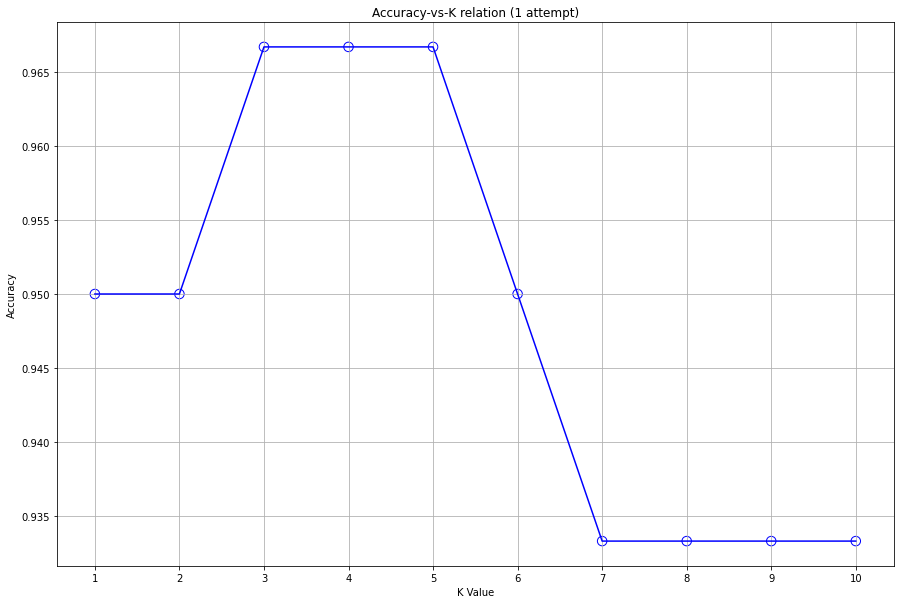

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get accuracy for each value of K in 1 to 10
ACCURACY = []
for k in range(1,11):
  knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
  knn.fit(X_train, Y_train)
  knn_predict = knn.predict(X_test)
  accuracy = accuracy_score(Y_test, knn_predict)
  ACCURACY.append(accuracy)
  print('K =',k,'->',accuracy)

# Plot Accuracy over K
fig, ax = plt.subplots(figsize=(15, 10));
ax.grid(True)
ax.set_title("Accuracy-vs-K relation (1 attempt)")
ax.set_xlabel("K Value")
ax.set_ylabel("Accuracy")
ax.set_xticks(range(1,11))
_ = ax.plot(range(1,11), ACCURACY, 'b')
_ = ax.scatter(range(1,11), ACCURACY, s=90, facecolors='none', edgecolors='b')


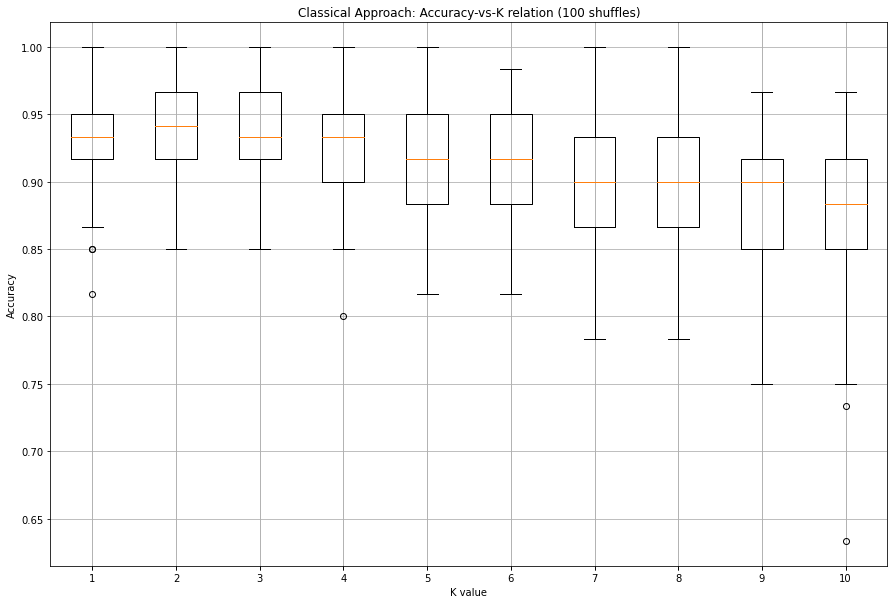

In [16]:
# Since the accuracy depends on how the set is splitted, let's analyze it from 
# the statistical point of view by collecting data with different shuffles

nb_attempts = 100 # parameter used also for the following 

ACCURACY = [[0 for x in range(nb_attempts)] for y in range(10)] 

# For each attempt get accuracy for each value of K in 1 to 10
for attempt in range(nb_attempts):
  for k in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    # ReSplit X_norm in train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.3, shuffle=True)
    knn.fit(X_train, Y_train)
    knn_predict = knn.predict(X_test)
    ACCURACY[k-1][attempt] = accuracy_score(Y_test, knn_predict)

plt.figure(figsize=(15,10))

plt.grid(visible=True)
plt.title("Classical Approach: Accuracy-vs-K relation ("+ str(nb_attempts) +" shuffles)")
plt.ylabel('Accuracy')
plt.xlabel('K value')
plt.xticks(range(1,11))
_ = plt.boxplot(ACCURACY)

The obtained accuracy depends on the homepages updates during the curls and how the dataset is splitted.

From boxplot it is possible to note that the average of the values ​​decreases as k increases, furthermore increasing k increases the variance of accuracy.

In general the obtained accuracy is acceptable (over 70% in most of the cases).

## 6. Create a new test set, visiting the same web sites (3 times) after some time (e.g., 1 day). Evaluate the performance obtained using the old training set and comment the results.

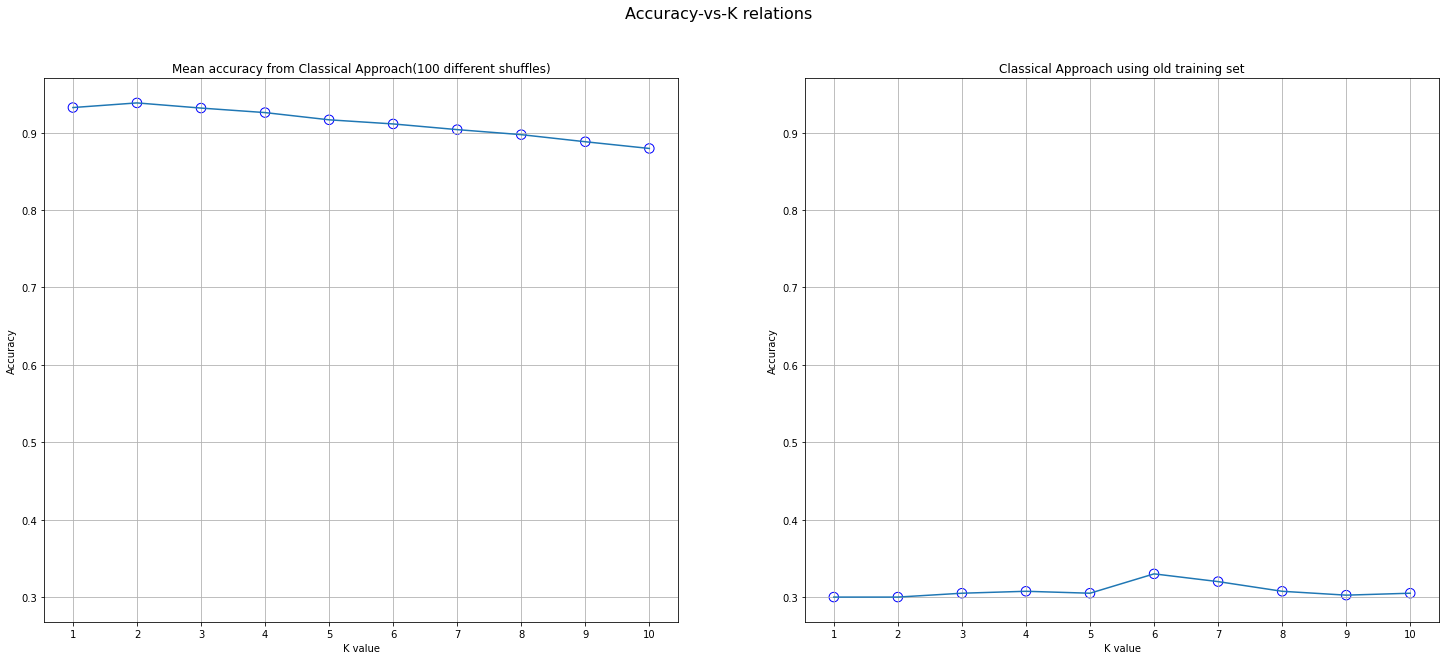

In [19]:
# load the dataset obtained in 26/03/22
old_biflow_features = pd.read_csv('26_03_22.csv')

X = old_biflow_features.drop(['sport','dport'],axis=1).dropna()
Y = X['website']
X = X.drop(['website'],axis=1)

ACCURACY_OLD_TRAIN = [0 for y in range(10)]

# As before, I analyzed the statistical accuracy with the same number of attempts
#for attempt in range(nb_attempts):
  # extract from it the 70% of the rows for training
X_train = X
Y_train = Y

# concatenate to the existing testing set the datasets obtained in the next days
csv_files = ['27_03_22.csv', '28_03_22.csv']
i=0 # variable to check if for is running the frist cycle (i=0) or not (i=1)
for csv_file in csv_files:
    new_biflow_features = pd.read_csv(csv_file)

    #Y_TEST
    # if it is the first cycle assign website column to Y_test 
    if i==0:
        Y_test = new_biflow_features['website']
    else: # otherwise concat new Y to Y_test
        Y_test = pd.concat([Y_test, new_biflow_features['website']])

    #X_TEST same procedure as Y_TEST
    new_biflow_features = new_biflow_features.drop(['sport','dport','website'],axis=1).dropna()
    if i==0:
        X_test = new_biflow_features
        i+=1
    else:
        X_test = np.concatenate([X_test, new_biflow_features.to_numpy()])

# Normalize X_train and X_test sets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# extract ACCURACY_OLD_TRAIN[k-1][attempt] for each k
for k in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, Y_train)
    knn_predict = knn.predict(X_test)
    accuracy = accuracy_score(Y_test, knn_predict)
    ACCURACY_OLD_TRAIN[k-1] = accuracy


# plot Accuracy over K comparing with the previous result to evaluate the perfomances
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,10))
f.suptitle("Accuracy-vs-K relations" , fontsize=16)

ax1.grid(visible=True)
ax1.set_title("Mean accuracy from Classical Approach("+ str(nb_attempts) +" different shuffles)")
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('K value')
ax1.set_xticks(range(1,11))
_ = ax1.plot(range(1,11),np.array(ACCURACY).mean(axis=1))
_ = ax1.scatter(range(1,11), np.array(ACCURACY).mean(axis=1), s=90, facecolors='none', edgecolors='b')

ax2.grid(visible=True)
ax2.set_title("Classical Approach using old training set")
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('K value')
ax2.set_xticks(range(1,11))
ax2.yaxis.set_tick_params(labelbottom=True)
_ = ax2.plot(range(1,11),ACCURACY_OLD_TRAIN)
_ = ax2.scatter(range(1,11), ACCURACY_OLD_TRAIN, s=90, facecolors='none', edgecolors='b')

As expected, the perfomances dropped significantly.

This deterioration in performance is because the news websites change frequently their homepage and consequently their size that should have changed the values of k-NN features.

## Bonus Point

In [20]:
# get_cumulative_function provides the cumulative trace of a bidirectional flow as described in the provided slide set
def get_cumulative_function(direction, df_flow, df_reverse_flow):
  c_funct = [0]

  # add the field 'downlink' to all packets to store its direction
  if direction == 'up':
    df_flow['downlink']=False
    df_reverse_flow['downlink']=True
  else:
    df_flow['downlink']=True
    df_reverse_flow['downlink']=False
  
  # join direct and reverse packets and sort by the frame number
  df_join = pd.concat([df_flow, df_reverse_flow]).sort_index()
  # exclude the TCP ACKs that do not carry data by removing all packets that contain no data and just acknowledge data coming from the other side
  df_join = df_join[df_join['tcp.len'] != 0]

  #display(df_join)
  # for each packet in the df_join
  for index, pkt in df_join.iterrows():
    # append its length with positive sign if incoming(downlink), negative sign otherwise (uplink)
    if pkt['downlink']:
      c_funct.append(c_funct[-1] + pkt['ip.len'])
    else:
      c_funct.append(c_funct[-1] - pkt['ip.len'])
  return c_funct

In [34]:
# As done previously, scan all measurement files to obtain the df_flows_tcp dataframe and
# compute the cumulative function for each flow/reverse flow using the function above
pd.options.mode.chained_assignment = None  # default='warn'
path = './26_03_22_captures/'
tsharkfiles = [f for f in listdir(path) if isfile(join(path, f))]

all_flows_fingerprints = pd.DataFrame(columns=['c_funct', 'website'])

for f in tsharkfiles:
  if (f.startswith('www') and f.endswith('.csv')):
    print('Processing file  ', f)
    df = pd.read_csv(join(path,f))
    df_tcp = df[df["ip.proto"] == 6]
    df_flows_tcp = df_tcp.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])
    to_ignore_flows = []
    for flow,df_flow in df_flows_tcp:
      if flow not in to_ignore_flows:
        reverse_flow = (flow[1], flow[0], flow[3], flow[2])
        if reverse_flow in df_flows_tcp.groups:
          df_reverse_flow = df_flows_tcp.get_group(reverse_flow)
          to_ignore_flows.append(reverse_flow)
        else:
          df_reverse_flow = pd.DataFrame()

        c_funct = get_cumulative_function(get_direction(flow[0]), df_flow, df_reverse_flow)
        all_flows_fingerprints.loc[len(all_flows_fingerprints.index)] = [c_funct, f[4:len(f)-4]]


Processing file   www.msn.com.csv
Processing file   www.indiatimes.com.csv
Processing file   www.theguardian.com.csv
Processing file   www.dailymail.co.uk.csv
Processing file   www.cnbc.com.csv
Processing file   www.ndtv.com.csv
Processing file   www.abc.net.au.csv
Processing file   www.news.google.com.csv
Processing file   www.express.co.uk.csv
Processing file   www.cnn.com.csv
Processing file   www.nypost.com.csv
Processing file   www.washingtonpost.com.csv
Processing file   www.foxnews.com.csv
Processing file   www.finance.yahoo.com.csv
Processing file   www.rt.com.csv
Processing file   www.bbc.co.uk.csv
Processing file   www.timesofindia.com.csv
Processing file   www.news18.com.csv
Processing file   www.news.yahoo.com.csv
Processing file   www.nytimes.com.csv


In [35]:
display(all_flows_fingerprints)

,c_funct,website
0,"[0, -557, 3416, 3218, 3309, 3418, 3325, 3229, ...",msn.com
1,"[0, -557, 3416, 3218, 3309, 3418, 3325, 3229, ...",msn.com
2,"[0, -557, 3416, 3218, 3309, 3418, 3325, 3229, ...",msn.com
3,"[0, -557, 3416, 3218, 3309, 3418, 3325, 3229, ...",msn.com
4,"[0, -557, 3416, 3218, 3309, 3418, 3325, 3229, ...",msn.com
...,...,...
196,"[0, -569, 3167, 3022, 3125, 3020, 2912, 2818, ...",nytimes.com
197,"[0, -569, 3167, 3022, 3125, 3020, 2912, 2818, ...",nytimes.com
198,"[0, -569, 3167, 3022, 3125, 3020, 2912, 2818, ...",nytimes.com
199,"[0, -569, 3167, 3022, 3125, 3020, 2912, 2818, ...",nytimes.com


In [36]:
# Number of samples of piecewise linear interpolant of the cumulative function
M = 20

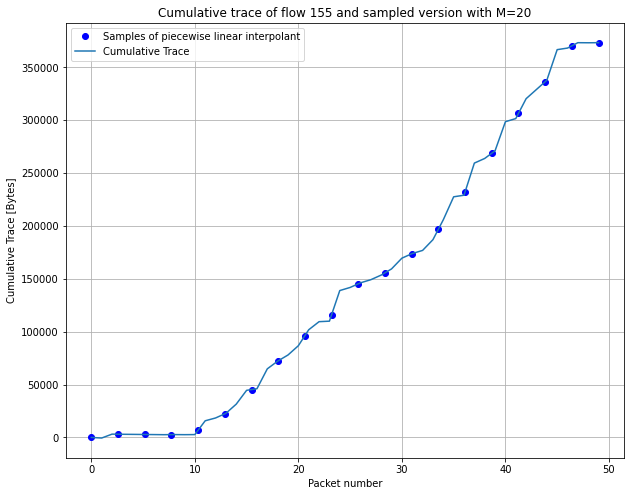

In [37]:
# Example to see what I have done:
# for each flow the algorithm will sample the piecewise linear interpolant of the cumulative function
n_flow = 155 # flow index to visualize
from_nth_packet = 0
up_to_nth_packet = 15 # how many packets
up_to_nth_packet = len(all_flows_fingerprints.loc[n_flow].c_funct) # comment this line if you want to analyze a limited nb. of pkts (up_to_nth_packet)

fp = all_flows_fingerprints.loc[n_flow].c_funct[from_nth_packet:up_to_nth_packet]

xp = range(0, up_to_nth_packet-from_nth_packet)
x = np.linspace(0, up_to_nth_packet-from_nth_packet-1, num=M)
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x, np.interp(x, xp, fp), 'bo', label='Samples of piecewise linear interpolant')
ax.plot(xp, fp, label='Cumulative Trace')
ax.legend()
ax.set_title('Cumulative trace of flow '+str(n_flow)+' and sampled version with M='+str(M))
ax.set_xlabel('Packet number')
ax.set_ylabel('Cumulative Trace [Bytes]')
ax.grid()

In [38]:
# Create X and Y arrays
cols = []
for i in range(0,M):
  cols.append("Sample #"+str(i))
X = pd.DataFrame(columns=cols)

for idx, flow in all_flows_fingerprints.iterrows():
  fp = all_flows_fingerprints.loc[idx].c_funct
  xp = range(0, len(fp))
  x = np.linspace(0, len(fp)-1, num=M)
  X = X.append(dict(zip(X.columns, np.interp(x, xp, fp).tolist())), ignore_index=True)

Y = all_flows_fingerprints['website']

# Normalization
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)


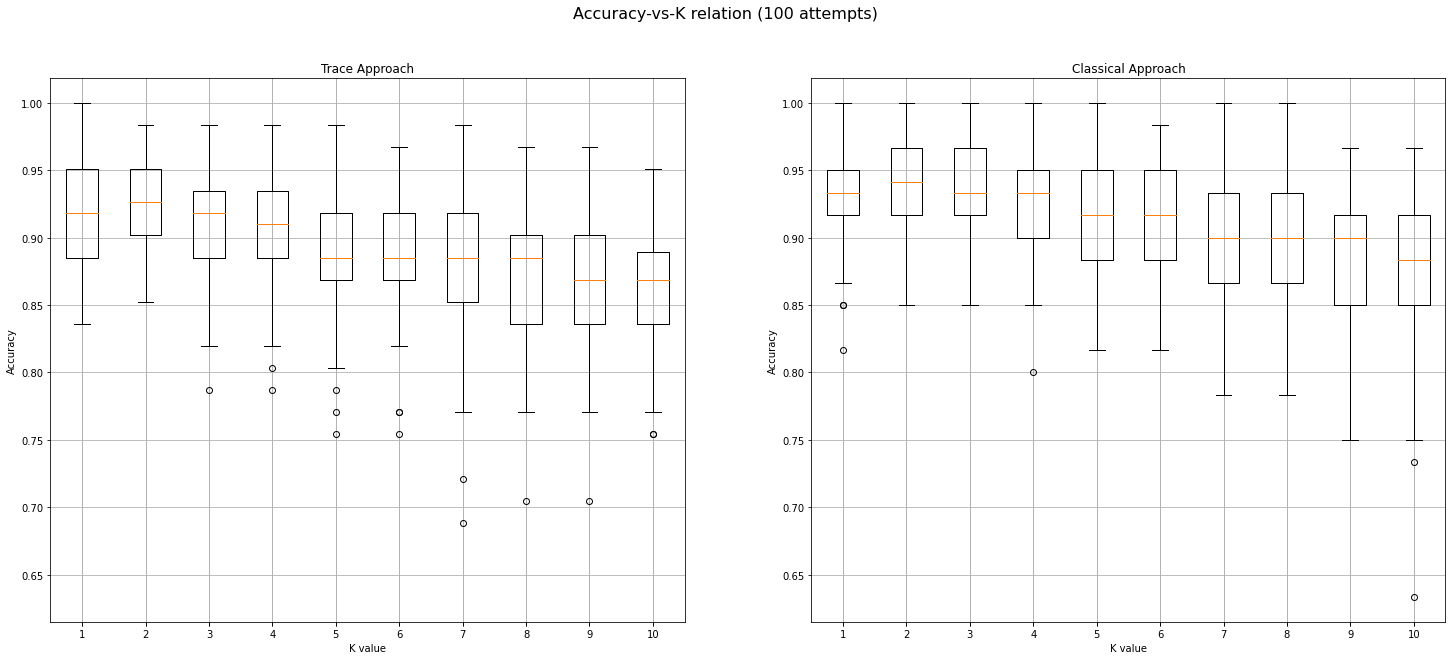

In [39]:
# Since the accuracy depends on how the set is splitted, let's analyze it from 
# the statistical point of view by collecting data with different shuffles
ACCURACY_TRACE = [[0 for x in range(nb_attempts)] for y in range(10)] 

# For each attempt get accuracy for each value of K in 1 to 10
for attempt in range(nb_attempts):
  for k in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    # ReSplit X_norm in train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.3, shuffle=True)
    knn.fit(X_train, Y_train)
    knn_predict = knn.predict(X_test)
    ACCURACY_TRACE[k-1][attempt] = accuracy_score(Y_test, knn_predict)

# plot Accuracy over K comparing with the classical approach
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,10))
f.suptitle("Accuracy-vs-K relation ("+ str(nb_attempts) +" attempts)", fontsize=16)

ax1.grid(visible=True)
ax1.set_title("Trace Approach")
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('K value')
ax1.set_xticks(range(1,11))
_ = ax1.boxplot(ACCURACY_TRACE)

ax2.grid(visible=True)
ax2.set_title("Classical Approach")
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('K value')
ax2.set_xticks(range(1,11))
ax2.yaxis.set_tick_params(labelbottom=True)
_ = ax2.boxplot(ACCURACY)

This method does performs more or less as the previous one. With respect to the classical approach it also consider the time evolution but both of them are based on the size of exchanged packets.